In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import sklearn
import scipy
from scipy.stats import nbinom
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
%matplotlib inline
print("Librerias cargadas correctamente.")

Librerias cargadas correctamente.


Preguntas:
1. Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario.

**R**: Para abordar esta situación, inicialmente identificamos que nuestra base de datos contenía una cantidad significativa de valores nulos. Por esta razón, decidimos transformar algunas variables en indicadores binarios: si el valor era NaN, se asignaba un 1, y si había información disponible, se asignaba un 0. Para las variables originales, los valores NaN se reemplazaron por ceros. Estas variables se incluyeron en todos los modelos que desarrollaremos, con el objetivo de analizar los efectos de la falta de información y los efectos de la presencia de datos. Esta estrategia se aplicó a las variables "Electricity", "Parameter6" y "Evaporation", que presentaban un alto porcentaje de datos faltantes. La variable parameter 6 no se considero para las primeras 5 preguntas.

A continuación, convertimos la variable "Failure_today" en una variable binaria y ajustamos el conjunto de datos en función de las fechas y las locaciones con mayor representatividad. En cuanto a las fechas, seleccionamos los registros a partir de 2009, y para las locaciones, optamos por conservar aquellas con mayor cantidad de datos, excluyendo únicamente tres.

Todos estos procesos y filtros se pueden revisar en detalle en el "Anexo", considerando en este análisis el conjunto de datos df_0.


In [2]:
# Cargamos la base de datos
df = pd.read_csv("machine_failure_data.csv", sep=";")

df_0 = df.copy()
df_1 = df.copy()

# Creamo columnas binarias donde 1 es NaN y 0 es no NaN
df['Electricity_binary'] = df['Electricity'].isnull().astype(int)
df['Evaporation_binary'] = df['Evaporation'].isnull().astype(int)

# Reemplazar NaN por 0 en las columnas originales
df['Electricity'] = df['Electricity'].fillna(0)
df['Evaporation'] = df['Evaporation'].fillna(0)


# Convertimos la columna 'Failure_today' de 'Yes'/'No' a 1/0 
df['Failure_today'] = df['Failure_today'].dropna()  # Eliminar valores nulos de 'Failure_today'
df['Failure_today_binary'] = df['Failure_today'].map({'Yes': 1, 'No': 0})
df = df.drop('Failure_today', axis=1)

# Unificamos los separadores a "-". de la variable 'Date'
df['Date'] = df['Date'].astype(str).str.replace(r"[/-]", "-", regex=True)

# Convertimos a datetime.
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year

# Filtramos los datos para considerar solo los años 2009 a 2017
df = df[(df['Year'] >= 2009) & (df['Year'] <= 2017)]

# Eliminamos las filas donde 'Location' es igual a 17, 26 o 42 debido a su poca frecuencia de datos
df = df[~df['Location'].isin([17, 26, 42])]

df = df.drop(['Parameter6_9am', 'Parameter6_3pm'], axis=1)

# 🧼 VALORES NULOS POR COLUMNA
print("🧼 VALORES NULOS POR COLUMNA")

nulls = df.isnull().sum().sort_values(ascending=False)
nulls_percent = (nulls / len(df) * 100).round(2)
null_summary = pd.DataFrame({'Nulos': nulls, '% Nulos': nulls_percent})

display(null_summary[null_summary['Nulos'] > 0])
print("\n")

🧼 VALORES NULOS POR COLUMNA


,Nulos,% Nulos
Parameter5_9am,13916,10.29
Parameter5_3pm,13882,10.26
Parameter2_9am,9783,7.23
Parameter1_Dir,8827,6.53
Parameter1_Speed,8768,6.48
Parameter2_3pm,3714,2.75
Parameter4_3pm,2767,2.05
Parameter3_3pm,2584,1.91
Parameter7_3pm,2002,1.48
Parameter4_9am,1671,1.24


In [3]:
# Calculamos el porcentaje de valores nulos por columna
missing_percentage = df.isnull().mean() * 100

# Filtramos las columnas con menos del 12% de valores nulos
columns_to_drop_na = missing_percentage[missing_percentage <= 12].index

# Eliminamos las filas con valores nulos solo de esas columnas
df = df.dropna(subset=columns_to_drop_na)

df.describe()

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Electricity_binary,Evaporation_binary,Failure_today_binary,Year
count,107545,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000,107545.000000
mean,2013-04-03 00:22:36.113254912,24.904366,12.645932,23.514835,2.419926,3.612611,4.674828,40.739625,15.148691,19.530318,67.753917,51.224780,1017.481403,1015.134115,17.417737,21.982897,0.394505,0.352885,0.228025,2012.765977
min,2009-01-01 00:00:00,1.000000,-8.200000,2.600000,0.000000,0.000000,0.000000,7.000000,2.000000,2.000000,0.000000,0.000000,980.500000,977.100000,-3.100000,1.700000,0.000000,0.000000,0.000000,2009.000000
25%,2011-01-20 00:00:00,12.000000,8.100000,18.200000,0.000000,0.000000,0.000000,31.000000,9.000000,13.000000,56.000000,37.000000,1012.900000,1010.400000,12.700000,16.900000,0.000000,0.000000,0.000000,2011.000000
50%,2013-05-03 00:00:00,23.000000,12.400000,23.000000,0.000000,2.600000,3.400000,39.000000,13.000000,19.000000,69.000000,52.000000,1017.500000,1015.100000,17.100000,21.500000,0.000000,0.000000,0.000000,2013.000000
75%,2015-05-29 00:00:00,38.000000,17.200000,28.500000,0.800000,6.000000,9.400000,48.000000,20.000000,24.000000,81.000000,65.000000,1022.200000,1019.800000,21.900000,26.700000,1.000000,1.000000,0.000000,2015.000000
max,2017-06-25 00:00:00,49.000000,33.900000,48.100000,367.600000,82.400000,14.500000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000,1.000000,1.000000,1.000000,2017.000000
std,NaN,14.549000,6.201391,6.877610,8.705487,4.329851,4.784612,13.357843,8.365156,8.591758,18.659158,20.583964,7.016194,6.932321,6.276722,6.726092,0.488746,0.477869,0.419561,2.483899


In [4]:
# Vemos las diferentes categorías de nuestas variables direciones.
print(df['Parameter1_Dir'].unique())
print(df['Parameter2_9am'].unique())
print(df['Parameter2_3pm'].unique())

['WNW' 'W' 'SSE' 'NE' 'S' 'SW' 'NNW' 'NW' 'SE' 'WSW' 'NNE' 'N' 'ESE' 'E'
 'SSW' 'ENE']
['W' 'WSW' 'SSE' 'ENE' 'SE' 'E' 'NNE' 'NE' 'N' 'S' 'ESE' 'SW' 'NNW' 'NW'
 'WNW' 'SSW']
['WNW' 'SSW' 'E' 'NW' 'W' 'WSW' 'S' 'N' 'SW' 'NNE' 'NNW' 'SSE' 'SE' 'NE'
 'ESE' 'ENE']


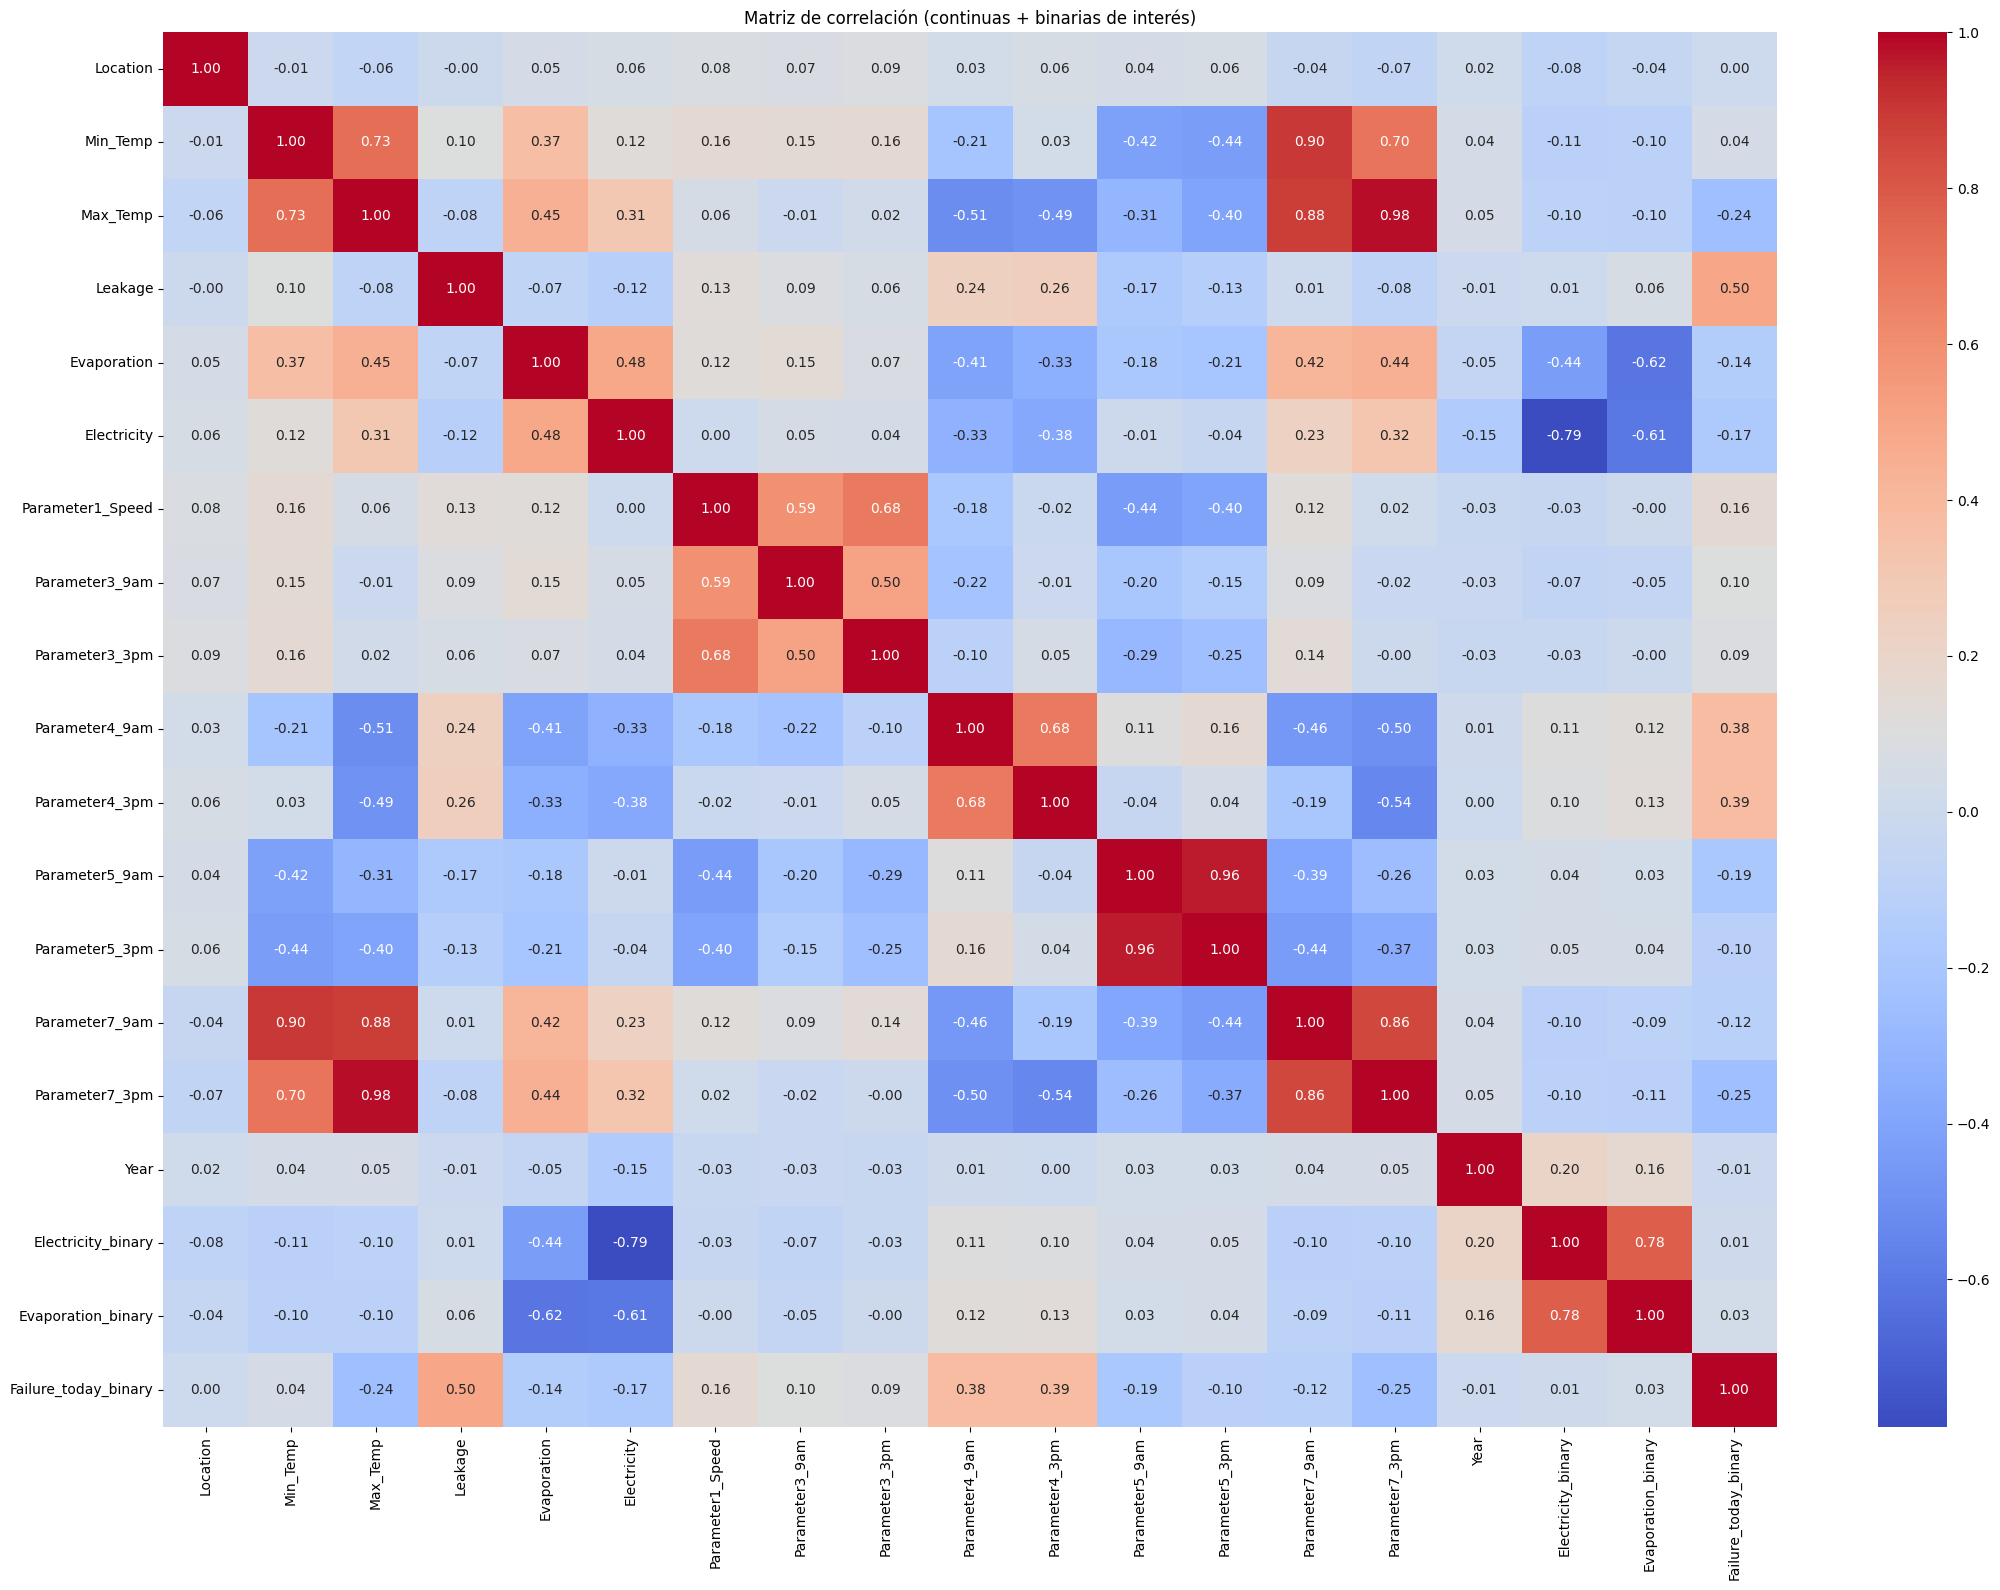

In [5]:
# Clasificamos las variables en relación a las direcciones agrupandolas en Norte, Sur, Este y Oeste
df['Parameter1_Dir'] = df['Parameter1_Dir'].str.strip().str.upper()
df['Parameter2_9am'] = df['Parameter2_9am'].str.strip().str.upper()
df['Parameter2_3pm'] = df['Parameter2_3pm'].str.strip().str.upper()

def group_direction(direction):
    norte = {'N', 'NNE', 'NNW', 'NE'}
    sur = {'S', 'SSE', 'SSW', 'SE'}
    este = {'E', 'ENE', 'ESE'}
    oeste = {'W', 'WSW', 'WNW', 'SW', 'NW'}
    
    if direction in norte:
        return 'Norte'
    elif direction in sur:
        return 'Sur'
    elif direction in este:
        return 'Este'
    elif direction in oeste:
        return 'Oeste'
    else:
        return 'Desconocido'

# Aplicar la función a las variables correspondientes
df['Parameter1_Dir_grouped'] = df['Parameter1_Dir'].apply(group_direction)
df['Parameter2_9am_grouped'] = df['Parameter2_9am'].apply(group_direction)
df['Parameter2_3pm_grouped'] = df['Parameter2_3pm'].apply(group_direction)

# Eliminamos las columnas originales de dirección
df = df.drop(['Parameter1_Dir', 'Parameter2_9am', 'Parameter2_3pm'], axis=1)

# Usamos One-Hot Encoding para las columnas de dirección y asegurarnos de que los valores sean 0 y 1
df = pd.get_dummies(df, columns=['Parameter1_Dir_grouped', 'Parameter2_9am_grouped', 'Parameter2_3pm_grouped'], drop_first=True)

# Convertimos dtypes 32-bit → 64-bit
for col in df.select_dtypes(include=['int32']).columns:
    df[col] = df[col].astype('int64')
for col in df.select_dtypes(include=['float32']).columns:
    df[col] = df[col].astype('float64')

# Identificamos variables continuas: más de 2 valores únicos
cont_cols = [
    col
    for col in df.select_dtypes(include=['int64','float64']).columns
    if df[col].nunique() > 2
]

# Añadimos las binarias que queremos incluir
binary_cols = ['Electricity_binary', 'Evaporation_binary', 'Failure_today_binary']

# Columnas para correlación
corr_cols = cont_cols + binary_cols

# Calculamos la matriz de correlación
corr = df[corr_cols].corr()

# Graficamos con seaborn
plt.figure(figsize=(22, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación (continuas + binarias de interés)')
plt.tight_layout()
plt.show()

In [6]:
# Ordenamos de mayor a menor las variables que más se correlacionan con 'Failure_today_binary'
correlacion = corr
correlacion_con_falla = correlacion['Failure_today_binary'].sort_values(ascending=False)
print(correlacion_con_falla)

Failure_today_binary    1.000000
Leakage                 0.495678
Parameter4_3pm          0.385026
Parameter4_9am          0.378975
Parameter1_Speed        0.156505
Parameter3_9am          0.102543
Parameter3_3pm          0.086130
Min_Temp                0.044627
Evaporation_binary      0.029645
Electricity_binary      0.014219
Location                0.004228
Year                   -0.007594
Parameter5_3pm         -0.103964
Parameter7_9am         -0.115421
Evaporation            -0.141851
Electricity            -0.169938
Parameter5_9am         -0.187387
Max_Temp               -0.244122
Parameter7_3pm         -0.250000
Name: Failure_today_binary, dtype: float64


2. Ejecute un modelo de probabilidad lineal (*MCO*) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R**: Para la selección de variables, se analizó inicialmente una matriz de correlación y se estimó un modelo de Mínimos Cuadrados Ordinarios (MCO) agrupando las variables en categorías: temperatura, velocidad del viento, electricidad–evaporación y direcciones, cabe destacar que la variable "Parameter1_Speed" se agrego al modelo debido a la mejora significativa en el R², aunque su coeficiente marginal no representa un alto valor porcentual. Dentro de cada grupo, se seleccionaron aquellas variables que presentaban los coeficientes betas más significativos estadísticamente. También verificamos si es que las variables eran significativas y que no tuviera un valor de VIF cercano o mayor a 5. Para nuesto caso se observa que las variables independientes explican en un 23.2% la variable independiente y que todas las variables seleccionadas son significativas debido a que su valor "p" es menor a 0.05. Cabe destacar que la variable "Leakage" no se considero en el modelo debido a su alto nivel de predicción de si es que ocurre una falla o no.

Además, se verificó que no existieran correlaciones fuertes entre las variables seleccionadas, descartando aquellas que presentaran coeficientes de correlación cercanos o superiores a ±0.8, para evitar problemas de multicolinealidad.

En cuanto al análisis de los coeficientes betas, los resultados fueron interpretados en una escala de 0 a 100, considerando su efecto porcentual. Por ejemplo, en el caso de la variable "Min_Temp", un aumento de una unidad en temperatura mínima se asocia a un incremento de aproximadamente 0.63 puntos porcentuales en la probabilidad de que ocurra una falla en la máquina.

In [7]:
# Seleccionamos las variables que usaremos para nuestro modelo "MCO"
columnas = ['Failure_today_binary', 'Parameter1_Speed','Electricity_binary','Electricity', 'Evaporation_binary', 'Evaporation', 'Parameter4_9am', 'Parameter5_3pm', 'Parameter2_9am_grouped_Sur', 'Parameter2_9am_grouped_Oeste', 'Min_Temp']
df_mco = df[columnas].copy()

# 1. Definimos las variables X e y
X = df_mco[['Parameter1_Speed','Electricity_binary','Electricity', 'Evaporation_binary','Evaporation','Parameter4_9am','Parameter5_3pm', 'Parameter2_9am_grouped_Sur', 'Parameter2_9am_grouped_Oeste', 'Min_Temp']]
X = X.astype(float)  # Aseguramos que todas las variables sean float para el modelo
y = df_mco['Failure_today_binary'].astype(float)

# 2. Agregamos la constante (término independiente en el modelo)
X = sm.add_constant(X)

# 3. Ajustamos el modelo OLS con errores estándar robustos (White robust)
modelo_mco_robusto = sm.OLS(y, X).fit(cov_type='HC0')

# 4. Vemos el resumen
print(modelo_mco_robusto.summary())

                             OLS Regression Results                             
Dep. Variable:     Failure_today_binary   R-squared:                       0.232
Model:                              OLS   Adj. R-squared:                  0.232
Method:                   Least Squares   F-statistic:                     3399.
Date:                  Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                          23:19:23   Log-Likelihood:                -45009.
No. Observations:                107545   AIC:                         9.004e+04
Df Residuals:                    107534   BIC:                         9.015e+04
Df Model:                            10                                         
Covariance Type:                    HC0                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [8]:
res = modelo_mco_robusto
signif = res.pvalues[res.pvalues < 0.05].index.drop('const')
print("Variables significativas:", list(signif))

Variables significativas: ['Parameter1_Speed', 'Electricity_binary', 'Electricity', 'Evaporation_binary', 'Evaporation', 'Parameter4_9am', 'Parameter5_3pm', 'Parameter2_9am_grouped_Sur', 'Parameter2_9am_grouped_Oeste', 'Min_Temp']


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame({
    'var': X.columns,
    'VIF': [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
})
print(vif_df)

                             var           VIF
0                          const  32436.897828
1               Parameter1_Speed      1.240311
2             Electricity_binary      4.837944
3                    Electricity      3.299780
4             Evaporation_binary      3.623046
5                    Evaporation      2.345444
6                 Parameter4_9am      1.429569
7                 Parameter5_3pm      1.475848
8     Parameter2_9am_grouped_Sur      1.225293
9   Parameter2_9am_grouped_Oeste      1.202282
10                      Min_Temp      1.464528


3. Ejecute un modelo *probit* para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R**: Al comparar el modelo Probit con el modelo de Mínimos Cuadrados Ordinarios (MCO), se observaron cambios importantes en los efectos marginales estimados, especialmente en las variables "Parameter2_9am_grouped_Sur", "Parameter2_9am_grouped_Oeste" y "Parameter4_9am", mostrando incrementos en su magnitud absoluta.

Las interpretaciones específicas para estas variables son:

Parameter2_9am_grouped_Sur: Si una observación pertenece al grupo "Sur" a las 9 am, la probabilidad promedio de que se reporte una falla aumenta en aproximadamente 8.56 puntos porcentuales, manteniendo constante el resto de las variables.

Parameter2_9am_grouped_Oeste: Si una observación pertenece al grupo "Oeste" a las 9 am, la probabilidad promedio de que ocurra una falla aumenta en cerca de 11.88 puntos porcentuales, respecto al grupo base, controlando por las demás variables.

Electricity_binary: El coeficiente de -0.0709 indica que, cuando hay datos disponibles en la columna de electricidad (es decir, cuando Electricity_binary = 0), la probabilidad de que ocurra una falla disminuye en aproximadamente 7.09 puntos porcentuales, manteniendo constantes todas las demás variables en el modelo.

Además, el modelo Probit mostró una mejora leve en términos del ajuste general respecto al modelo MCO, incrementando el Pseudo R² a 0.2559 frente al R² original de 0.232. Esto indica que bajo el modelo Probit, las variables seleccionadas explican aproximadamente el 25.59% de la variabilidad en la ocurrencia de fallas, representando una mejora de aproximadamente 2.39 puntos porcentuales en comparación al modelo lineal tradicional. Asimismo las variables son todas significativas debido a que su valores "p" son menor a 0.05 y sus intervalos de confianza no incluyen el 0.

In [10]:
probit_model = smf.probit(
    "Failure_today_binary ~ Parameter1_Speed + Electricity_binary + Electricity + Evaporation_binary + Evaporation + Parameter4_9am + Parameter5_3pm + Parameter2_9am_grouped_Sur + Parameter2_9am_grouped_Oeste + Min_Temp", 
    data=df_mco
).fit()

print(probit_model.summary())

mfx = probit_model.get_margeff()
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.399473
         Iterations 6
                           Probit Regression Results                            
Dep. Variable:     Failure_today_binary   No. Observations:               107545
Model:                           Probit   Df Residuals:                   107534
Method:                             MLE   Df Model:                           10
Date:                  Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2559
Time:                          23:19:24   Log-Likelihood:                -42961.
converged:                         True   LL-Null:                       -57739.
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               

4. Ejecute un modelo *logit*  para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R**: Respecto al modelo "Logit" todos los valores p son menos a 0.05 por lo que estadísticamente son significativos, ademas el pseudo R² nos indica que el modelo explica aproximadamente un 25.84% de los datos. Siendo más relevantes los coeficientes marginales de las variables:

Parameter2_9am_grouped_Sur: Si una observación pertenece al grupo "Sur" a las 9 am, la probabilidad promedio de que se reporte una falla aumenta en aproximadamente 8.49 puntos porcentuales, manteniendo constante el resto de las variables.

Parameter2_9am_grouped_Oeste: Si una observación pertenece al grupo "Oeste" a las 9 am, la probabilidad promedio de que ocurra una falla aumenta en cerca de 11.70 puntos porcentuales, respecto al grupo base, controlando por las demás variables.

Electricity_binary: El coeficiente de -0.0752 indica que, cuando hay datos disponibles en la columna de electricidad (es decir, cuando Electricity_binary = 0), la probabilidad de que ocurra una falla disminuye en aproximadamente 7.52 puntos porcentuales, manteniendo constantes todas las demás variables en el modelo.

In [11]:
logit_model = smf.logit(
    "Failure_today_binary ~ Parameter1_Speed + Electricity_binary + Electricity + Evaporation_binary + Evaporation + Parameter4_9am + Parameter5_3pm + Parameter2_9am_grouped_Sur + Parameter2_9am_grouped_Oeste + Min_Temp", 
    data=df_mco
).fit()

print(logit_model.summary())

mfx = logit_model.get_margeff()
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.398146
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     Failure_today_binary   No. Observations:               107545
Model:                            Logit   Df Residuals:                   107534
Method:                             MLE   Df Model:                           10
Date:                  Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2584
Time:                          23:19:25   Log-Likelihood:                -42819.
converged:                         True   LL-Null:                       -57739.
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               

5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investigación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R**: Según los resultados obtenidos, el modelo MCO no se adecua bien para estimar probabilidades en variables binarias, ya que asume un comportamiento lineal que no se ajusta a las características propias de este tipo de variables. Por lo tanto, no es el modelo más apropiado para predecir si una máquina fallará o no en función de las variables explicativas. Esto se puede observar en el gráfico del anexo.

En cuanto al modelo Probit, fue el que obtuvo los mejores resultados en términos de efectos marginales al compararlo con el MCO y el Logit. Sin embargo, para grandes volúmenes de datos, suele recomendarse el uso del modelo Logit por su mayor eficiencia computacional.

Respecto a la capacidad explicativa, el modelo Logit superó ligeramente al Probit por 0.25 puntos porcentuales, logrando explicar aproximadamente el 25.84 de la variabilidad de la variable dependiente, frente al 25.59% obtenido por el Probit.

A pesar de contar con una gran cantidad de datos, los resultados estadísticos demuestran que el modelo Probit es el más adecuado para nuestro análisis de predicción de fallas en una máquina, gracias a la solidez de sus efectos marginales y su buen desempeño general.


-------------------------------------------------------------------------------------------------------------------------------

6. Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R**: Para este modelo, inicialmente se utilizó todas las variables continuas, lo que resultó en algunas variables no significativas. Por lo tanto, se decidió ajustar el modelo nuevamente, considerando únicamente las variables significativas, que son: 'Min_Temp', 'Max_Temp', 'Parameter1_Speed', 'Parameter3_3pm', 'Parameter4_9am', 'Parameter5_9am', 'Parameter6_3pm', 'Parameter7_9am', 'Parameter7_3pm', 'Electricity', 'Evaporation', 'Electricity_binary' y 'Evaporation_binary'. Esta segunda estimación del modelo Poisson se realizó con el objetivo de mejorar los resultados y la precisión de la estimación. Tras ejecutar el modelo, se observó que todas las variables eran significativas, ya que sus valores p eran menores que 0.05. Y que el modelo es capaz de explicar aproximadamente en un 85.61% de los datos.

En cuanto a la interpretación de las variables, tenemos, por ejemplo, para 'Min_Temp' un coeficiente de -0.0170. Al aplicar exp de este coeficiente, obtenemos aproximadamente 0.9831, lo que implica que un aumento de una unidad en la temperatura mínima disminuirá la tasa de fallas en aproximadamente un 1.69%. Por otro lado, para 'Parameter1_Speed', el coeficiente es 0.0452, y al aplicar exp de este valor, obtenemos aproximadamente 1.046, lo que sugiere que un aumento en la velocidad aumenta la tasa de fallas en aproximadamente un 4.62%.

In [12]:
# Limpiamos el df_1 para su uso
df_1['Failure_today_binary'] = df_1['Failure_today'].map({'Yes': 1, 'No': 0})
df_1 = df_1.drop('Failure_today', axis=1)

# Unificamos los separadores a "-". de la variable 'Date'
df_1['Date'] = df_1['Date'].astype(str).str.replace(r"[/-]", "-", regex=True)

# Convertimos a datetime.
df_1['Date'] = pd.to_datetime(df_1['Date'], errors='coerce')
df_1['Year'] = df_1['Date'].dt.year  # Añadimos el año

# Filtramos los datos para considerar solo los años 2009 a 2017
df_1 = df_1[(df_1['Year'] >= 2009) & (df_1['Year'] <= 2017)]

# Filtramos las ubicaciones 17, 26, 42 en df_1
df_1 = df_1[~df_1['Location'].isin([17, 26, 42])]

# Agrupamos nuestros datos por ubicación, mes y año, calculando la media de cada variable agrupada y contando la cantidad de fallas por mes
df_1['Month'] = pd.to_datetime(df_1['Date']).dt.to_period('M')

df_1 = df_1.groupby(['Location', 'Month', 'Year']).agg({
    'Failure_today_binary':'sum',  # Contamos el número de fallas
    'Min_Temp':'mean','Max_Temp':'mean',
    'Parameter1_Speed':'mean',
    'Parameter3_9am':'mean','Parameter3_3pm':'mean',
    'Parameter4_9am':'mean','Parameter4_3pm':'mean',
    'Parameter5_9am':'mean','Parameter5_3pm':'mean',
    'Parameter6_9am':'mean','Parameter6_3pm' :'mean',
    'Parameter7_9am':'mean','Parameter7_3pm':'mean',
    'Electricity' : 'mean', 'Evaporation' : 'mean'
}).rename(columns={'Failure_today_binary':'Failures_per_month_Year'}).reset_index()

# Asignamos 1 a los valores NaN y 0 a los no NaN para columnas específicas
df_1['Electricity_binary'] = df_1['Electricity'].isnull().astype(int)
df_1['Evaporation_binary'] = df_1['Evaporation'].isnull().astype(int)
df_1['Parameter6_9am_binary'] = df_1['Parameter6_9am'].isnull().astype(int)
df_1['Parameter6_3pm_binary'] = df_1['Parameter6_3pm'].isnull().astype(int)

# Reemplazamos NaN por 0 en las columnas originales
df_1['Electricity'] = df_1['Electricity'].fillna(0)
df_1['Evaporation'] = df_1['Evaporation'].fillna(0)
df_1['Parameter6_9am'] = df_1['Parameter6_9am'].fillna(0)
df_1['Parameter6_3pm'] = df_1['Parameter6_3pm'].fillna(0)

# Eliminar filas con valores nulos
df_1 = df_1.dropna()

# Resetear los índices
df_1 = df_1.reset_index(drop=True)

In [13]:
from statsmodels.genmod.families import Poisson

y = df_1['Failures_per_month_Year']

x = df_1.drop(['Location','Month','Failures_per_month_Year'], axis=1)

x = sm.add_constant(x)

poisson = sm.GLM(y, x, family=Poisson()).fit(cov_type='HC0')

print(poisson.summary())

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Failures_per_month_Year   No. Observations:                 3943
Model:                                 GLM   Df Residuals:                     3922
Model Family:                      Poisson   Df Model:                           20
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -9086.4
Date:                     Thu, 24 Apr 2025   Deviance:                       4674.8
Time:                             23:19:27   Pearson chi2:                 4.33e+03
No. Iterations:                          5   Pseudo R-squ. (CS):             0.8581
Covariance Type:                       HC0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [14]:
# 1) Identificamos las variables con p-valor < 0.05
signif = poisson.pvalues[poisson.pvalues < 0.05].index

# 2) Calculamos IRR = exp(beta) solo para esas variables
irrs = np.exp(poisson.params.loc[signif])

# 3) Mostramos IRR junto a sus p-valores
for var in signif:
    print(f"{var:20s}  p={poisson.pvalues[var]:.3f}  IRR={irrs[var]:.3f}")

const                 p=0.000  IRR=20279874845504.645
Min_Temp              p=0.026  IRR=0.983
Max_Temp              p=0.000  IRR=0.912
Parameter1_Speed      p=0.000  IRR=1.046
Parameter3_3pm        p=0.000  IRR=0.944
Parameter4_9am        p=0.000  IRR=1.032
Parameter5_9am        p=0.026  IRR=0.970
Parameter6_3pm        p=0.000  IRR=1.074
Parameter7_9am        p=0.000  IRR=1.194
Parameter7_3pm        p=0.021  IRR=0.944
Electricity           p=0.000  IRR=0.968
Evaporation           p=0.018  IRR=0.989
Electricity_binary    p=0.000  IRR=0.742
Evaporation_binary    p=0.019  IRR=0.923
Parameter6_3pm_binary  p=0.003  IRR=1.423


In [15]:
# Poisson con solo las variables significativas (p < 0.05)
X_significativas = df_1[['Min_Temp','Max_Temp', 'Parameter1_Speed', 'Parameter3_3pm', 'Parameter4_9am', 
                         'Parameter5_9am', 'Parameter6_3pm','Parameter7_9am', 'Parameter7_3pm', 'Electricity', 
                         'Evaporation', 'Electricity_binary', 'Evaporation_binary']]

# Agrega una constante
X_significativas = sm.add_constant(X_significativas)

# Variable dependiente: Fallas por mes
y = df_1['Failures_per_month_Year']

# Ajuste del modelo Poisson
poisson_model = sm.GLM(y, X_significativas, family=sm.families.Poisson()).fit()

# Resumen del modelo
print(poisson_model.summary())


                    Generalized Linear Model Regression Results                    
Dep. Variable:     Failures_per_month_Year   No. Observations:                 3943
Model:                                 GLM   Df Residuals:                     3929
Model Family:                      Poisson   Df Model:                           13
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -9115.0
Date:                     Thu, 24 Apr 2025   Deviance:                       4732.2
Time:                             23:19:27   Pearson chi2:                 4.41e+03
No. Iterations:                          5   Pseudo R-squ. (CS):             0.8561
Covariance Type:                 nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

7. Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.

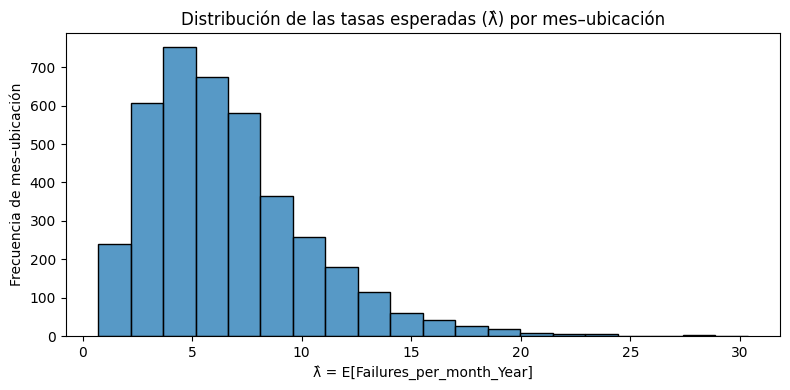

In [16]:
# 1) Saca las predicciones de la media:
df_1['lambda_hat'] = poisson_model.mu

# 2) Histograma de esas tasas esperadas
plt.figure(figsize=(8,4))
sns.histplot(df_1['lambda_hat'], bins=20, kde=False)
plt.title("Distribución de las tasas esperadas (λ̂) por mes–ubicación")
plt.xlabel("λ̂ = E[Failures_per_month_Year]")
plt.ylabel("Frecuencia de mes–ubicación")
plt.tight_layout()
plt.show()

In [17]:
aux=((y-poisson_model.mu)**2-poisson_model.mu)/poisson_model.mu
auxr=sm.OLS(aux,poisson_model.mu).fit()
print(auxr.summary())

                                   OLS Regression Results                                   
Dep. Variable:     Failures_per_month_Year   R-squared (uncentered):                   0.000
Model:                                 OLS   Adj. R-squared (uncentered):              0.000
Method:                      Least Squares   F-statistic:                              1.537
Date:                     Thu, 24 Apr 2025   Prob (F-statistic):                       0.215
Time:                             23:19:28   Log-Likelihood:                         -10523.
No. Observations:                     3943   AIC:                                  2.105e+04
Df Residuals:                         3942   BIC:                                  2.105e+04
Df Model:                                1                                                  
Covariance Type:                 nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

In [18]:
# Posible valor de alfa
print(np.exp(0.0090))

1.0090406217738679


8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R**: Se concluye que todas las variables son estadisticamente significativas, cumpliendo el criterio de significancia con un valor p inferior a 0.05, además el modelo explica aproximadamente el 18.30%  de la variabilidad en la variable dependiente. Las variables con mayor incidencia en que la tasa de fallas por locación en cada mes aumente o disminuya corresponde a las variables: "Electricity_binary" y "Parameter7_9am". En donde si es que tenemos ausencia de datos de electricidad se asocia con la disminución de fallas y en caso de aumento de una unidad del Parameter7_9am indica un aumento en la tasa de fallas.

In [19]:
# Ajustar el modelo Negative Binomial
nbin = smf.negativebinomial(
    "Failures_per_month_Year ~ Min_Temp + Max_Temp + Parameter1_Speed + Parameter3_3pm + Parameter4_9am + "
    "Parameter5_9am + Parameter6_3pm + Parameter7_9am + Parameter7_3pm + Electricity + "
    "Evaporation + Electricity_binary + Evaporation_binary", 
    data=df_1
).fit()

# Mostrar el resumen del modelo
print(nbin.summary())

         Current function value: 2.310446
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 52
                        NegativeBinomial Regression Results                        
Dep. Variable:     Failures_per_month_Year   No. Observations:                 3943
Model:                    NegativeBinomial   Df Residuals:                     3929
Method:                                MLE   Df Model:                           13
Date:                     Thu, 24 Apr 2025   Pseudo R-squ.:                  0.1830
Time:                             23:19:28   Log-Likelihood:                -9110.1
converged:                           False   LL-Null:                       -11150.
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           

c:\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
c:\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:3379: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
c:\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:1397: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
c:\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
# Posible valor del alfa
print(np.exp(0.0102))

1.010252197319935


In [21]:
# Obtener las predicciones del modelo Negative Binomial
df_1['ypred'] = nbin.predict(df_1)

# Ver las primeras filas para confirmar que las predicciones se añadieron correctamente
print(df_1[['ypred']].head())

      ypred
0  1.301432
1  1.741632
2  3.049850
3  4.012339
4  8.001066


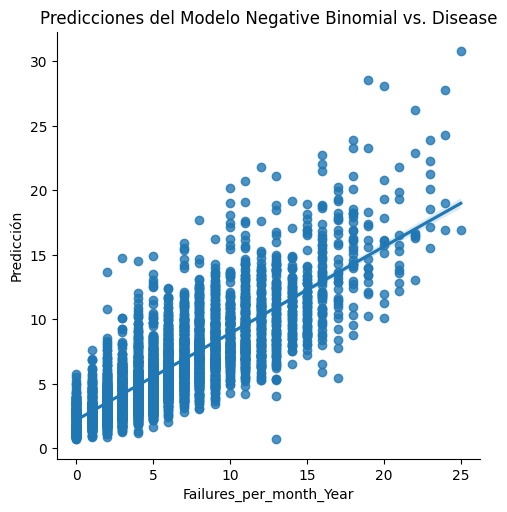

In [22]:
sns.lmplot(data=df_1, x='Failures_per_month_Year', y='ypred')

# Título y etiquetas
plt.title('Predicciones del Modelo Negative Binomial vs. Disease')
plt.xlabel('Failures_per_month_Year')
plt.ylabel('Predicción')
plt.show()

9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R**: Para este análisis, se realizaron tres modelos para estudiar la incidencia de las variables sobre las fallas. El modelo Poisson resultó ser el más adecuado, con un Pseudo R-squ. de 0.8561, lo que indica que explica un 85.61% de la variabilidad en las fallas y muestra que variables como Min_Temp y Parameter1_Speed son significativas. El modelo OLS no fue útil, con un R-squared de 0.000, lo que sugiere que no es adecuado para datos de conteo. Por otro lado, el modelo binomial negativo, con un Pseudo R-squ. de 0.1830, aunque menos ajustado que el Poisson, captura la sobredispersión de los datos, como indica el valor significativo de alfa. Las variables más robustas a la especificación fueron Parameter7_9am y Electricity_binary, que resultaron significativas en ambos modelos. En mi opinión, el modelo Poisson es el más adecuado para responder la pregunta de investigación, ya que captura la relación entre las variables y las fallas de manera más precisa.

# Anexos

In [23]:
# 🧼 VALORES NULOS POR COLUMNA
print("🧼 VALORES NULOS POR COLUMNA")

nulls = df_0.isnull().sum().sort_values(ascending=False)
nulls_percent = (nulls / len(df_0) * 100).round(2)
null_summary = pd.DataFrame({'Nulos': nulls, '% Nulos': nulls_percent})

display(null_summary[null_summary['Nulos'] > 0])
print("\n")

🧼 VALORES NULOS POR COLUMNA


,Nulos,% Nulos
Electricity,67816,47.69
Evaporation,60843,42.79
Parameter6_3pm,57094,40.15
Parameter6_9am,53657,37.74
Parameter5_9am,14014,9.86
Parameter5_3pm,13981,9.83
Parameter2_9am,10013,7.04
Parameter1_Dir,9330,6.56
Parameter1_Speed,9270,6.52
Parameter2_3pm,3778,2.66


In [24]:
df_0.describe()

,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter6_9am,Parameter6_3pm,Parameter7_9am,Parameter7_3pm
count,142193.000000,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,24.740655,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,14.237503,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,1.000000,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,12.000000,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,25.000000,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,37.000000,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,49.000000,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


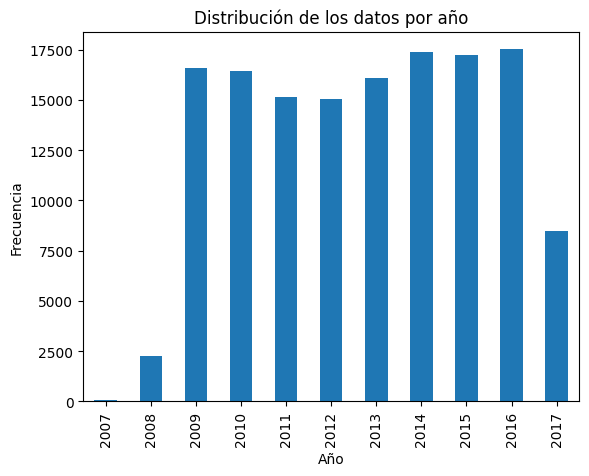

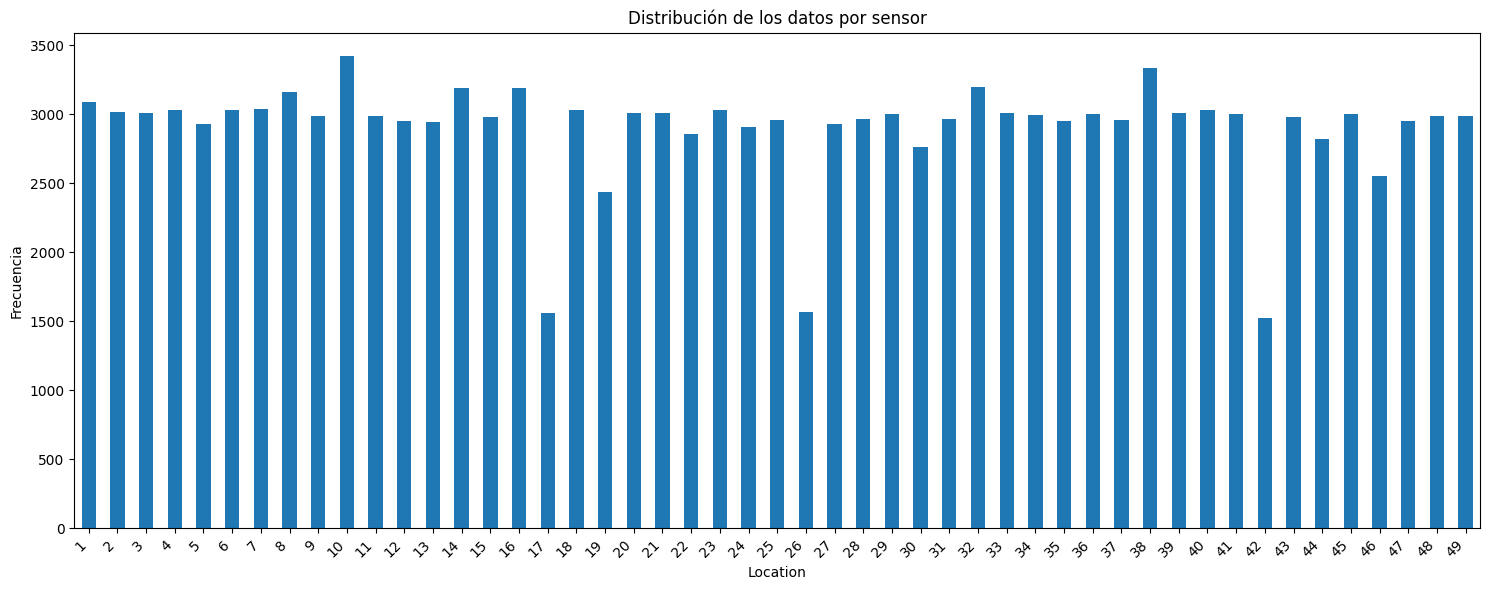

In [25]:
# Primero unificamos los separadores a "-".
df_0['Date'] = df_0['Date'].astype(str).str.replace(r"[/-]", "-", regex=True)

# Segundo convertimos a datetime.
df_0['Date'] = pd.to_datetime(df_0['Date'], errors='coerce')

# Agregamos nuevas columnas a nuestro df_1 que servirán para el desarrollo de las preguntas 1 a la 5
df_0['Year'] = df_0['Date'].dt.year

# Graficar la distribución de datos por año
df_0['Year'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de los datos por año')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(15, 6))

# Gráficar la distribución de datos por Location
df_0['Location'].value_counts().sort_index().plot(kind='bar')

plt.title('Distribución de los datos por sensor')
plt.xlabel('Location')
plt.ylabel('Frecuencia')

plt.xticks(rotation=45, ha='right')

# Ajuste del layout
plt.tight_layout()
plt.show()

# Interpretación 1 selección de variables

In [26]:
# Seleccionamos las variables que usaremos para nuestro modelo "MCO"
columnas = ['Failure_today_binary','Min_Temp', 'Max_Temp','Parameter4_3pm', 'Parameter4_9am','Parameter7_3pm', 'Parameter7_9am']
df_mco = df[columnas].copy()


# 1. Definimos las variables X e y
X = df_mco[[ 'Min_Temp', 'Max_Temp','Parameter4_3pm', 'Parameter4_9am','Parameter7_3pm', 'Parameter7_9am']]
X = X.astype(float)  # Aseguramos que todas las variables sean float para el modelo
y = df_mco['Failure_today_binary'].astype(float)

# 2. Agregamos la constante (término independiente en el modelo)
X = sm.add_constant(X)

# 3. Ajustamos el modelo OLS con errores estándar robustos (White robust)
modelo_mco_robusto = sm.OLS(y, X).fit(cov_type='HC0')

# 4. Vemos el resumen
print(modelo_mco_robusto.summary())

                             OLS Regression Results                             
Dep. Variable:     Failure_today_binary   R-squared:                       0.213
Model:                              OLS   Adj. R-squared:                  0.213
Method:                   Least Squares   F-statistic:                     5271.
Date:                  Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                          23:19:30   Log-Likelihood:                -46311.
No. Observations:                107545   AIC:                         9.264e+04
Df Residuals:                    107538   BIC:                         9.270e+04
Df Model:                             6                                         
Covariance Type:                    HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.054

# Interpretación 2 selección de variables

In [27]:
# Seleccionamos las variables del grupo de electricidad y evaporación
columnas_electricidad_evaporacion = ['Failure_today_binary', 'Electricity_binary', 'Evaporation_binary']
df_electricidad_evaporacion = df[columnas_electricidad_evaporacion].copy()

# 1. Definimos las variables X e y
X_electricidad_evaporacion = df_electricidad_evaporacion[['Electricity_binary', 'Evaporation_binary']]
X_electricidad_evaporacion = X_electricidad_evaporacion.astype(float)  # Aseguramos que todas las variables sean float para el modelo
y_electricidad_evaporacion = df_electricidad_evaporacion['Failure_today_binary'].astype(float)

# 2. Agregamos la constante (término independiente en el modelo)
X_electricidad_evaporacion = sm.add_constant(X_electricidad_evaporacion)

# 3. Ajustamos el modelo OLS con errores estándar robustos (White robust)
modelo_electricidad_evaporacion = sm.OLS(y_electricidad_evaporacion, X_electricidad_evaporacion).fit(cov_type='HC0')

# 4. Vemos el resumen
print(modelo_electricidad_evaporacion.summary())

                             OLS Regression Results                             
Dep. Variable:     Failure_today_binary   R-squared:                       0.001
Model:                              OLS   Adj. R-squared:                  0.001
Method:                   Least Squares   F-statistic:                     58.14
Date:                  Thu, 24 Apr 2025   Prob (F-statistic):           5.80e-26
Time:                          23:19:30   Log-Likelihood:                -59133.
No. Observations:                107545   AIC:                         1.183e+05
Df Residuals:                    107542   BIC:                         1.183e+05
Df Model:                             2                                         
Covariance Type:                    HC0                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

# Interpretación 3 selección de variables

In [28]:
# Seleccionamos las variables del grupo de viento
columnas_viento = ['Failure_today_binary','Parameter1_Speed',
                   'Parameter3_3pm', 'Parameter3_9am', 'Parameter5_3pm', 'Parameter5_9am',]
df_viento = df[columnas_viento].copy()

# 1. Definimos las variables X e y
X_viento = df_viento.drop('Failure_today_binary', axis=1)
X_viento = X_viento.astype(float)  # Aseguramos que todas las variables sean float para el modelo
y_viento = df_viento['Failure_today_binary'].astype(float)

# 2. Agregamos la constante (término independiente en el modelo)
X_viento = sm.add_constant(X_viento)

# 3. Ajustamos el modelo OLS con errores estándar robustos (White robust)
modelo_viento = sm.OLS(y_viento, X_viento).fit(cov_type='HC0')

# 4. Vemos el resumen
print(modelo_viento.summary())

                             OLS Regression Results                             
Dep. Variable:     Failure_today_binary   R-squared:                       0.113
Model:                              OLS   Adj. R-squared:                  0.113
Method:                   Least Squares   F-statistic:                     2431.
Date:                  Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                          23:19:30   Log-Likelihood:                -52748.
No. Observations:                107545   AIC:                         1.055e+05
Df Residuals:                    107539   BIC:                         1.056e+05
Df Model:                             5                                         
Covariance Type:                    HC0                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

# Interpretación 4 selección de variables

In [29]:
# Seleccionamos las variables del grupo de localización y falla
columnas_localizacion_falla = ['Failure_today_binary', 'Location', 'Year']
df_localizacion_falla = df[columnas_localizacion_falla].copy()

# 1. Definimos las variables X e y
X_localizacion_falla = df_localizacion_falla[['Location', 'Year']]
X_localizacion_falla = X_localizacion_falla.astype(float)  # Aseguramos que todas las variables sean float para el modelo
y_localizacion_falla = df_localizacion_falla['Failure_today_binary'].astype(float)

# 2. Agregamos la constante (término independiente en el modelo)
X_localizacion_falla = sm.add_constant(X_localizacion_falla)

# 3. Ajustamos el modelo OLS con errores estándar robustos (White robust)
modelo_localizacion_falla = sm.OLS(y_localizacion_falla, X_localizacion_falla).fit(cov_type='HC0')

# 4. Vemos el resumen
print(modelo_localizacion_falla.summary())

                             OLS Regression Results                             
Dep. Variable:     Failure_today_binary   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                  0.000
Method:                   Least Squares   F-statistic:                     4.182
Date:                  Thu, 24 Apr 2025   Prob (F-statistic):             0.0153
Time:                          23:19:31   Log-Likelihood:                -59187.
No. Observations:                107545   AIC:                         1.184e+05
Df Residuals:                    107542   BIC:                         1.184e+05
Df Model:                             2                                         
Covariance Type:                    HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8332      1.038

# Interpretación 5 selección de variables

In [30]:
# Seleccionamos las variables del grupo de filtración
columnas_filtracion = ['Failure_today_binary', 'Leakage']
df_filtracion = df[columnas_filtracion].copy()

# 1. Definimos las variables X e y
X_filtracion = df_filtracion[['Leakage']]
X_filtracion = X_filtracion.astype(float)  # Aseguramos que todas las variables sean float para el modelo
y_filtracion = df_filtracion['Failure_today_binary'].astype(float)

# 2. Agregamos la constante (término independiente en el modelo)
X_filtracion = sm.add_constant(X_filtracion)

# 3. Ajustamos el modelo OLS con errores estándar robustos (White robust)
modelo_filtracion = sm.OLS(y_filtracion, X_filtracion).fit(cov_type='HC0')

# 4. Vemos el resumen
print(modelo_filtracion.summary())

                             OLS Regression Results                             
Dep. Variable:     Failure_today_binary   R-squared:                       0.246
Model:                              OLS   Adj. R-squared:                  0.246
Method:                   Least Squares   F-statistic:                     1017.
Date:                  Thu, 24 Apr 2025   Prob (F-statistic):          4.03e-222
Time:                          23:19:31   Log-Likelihood:                -44030.
No. Observations:                107545   AIC:                         8.806e+04
Df Residuals:                    107543   BIC:                         8.808e+04
Df Model:                             1                                         
Covariance Type:                    HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1702      0.002

# Interpretación 6 selección de variables


In [31]:
# Seleccionamos las variables del grupo de direcciones
columnas_direcciones = ['Failure_today_binary', 
                         'Parameter1_Dir_grouped_Norte', 
                         'Parameter1_Dir_grouped_Sur', 'Parameter1_Dir_grouped_Oeste', 
                         'Parameter2_9am_grouped_Norte', 
                         'Parameter2_9am_grouped_Sur', 'Parameter2_9am_grouped_Oeste', 
                         'Parameter2_3pm_grouped_Norte', 
                         'Parameter2_3pm_grouped_Sur', 'Parameter2_3pm_grouped_Oeste']

# Crear el DataFrame para las direcciones
df_direcciones = df[columnas_direcciones].copy()

# 1. Definimos las variables X e y
X_direcciones = df_direcciones.drop('Failure_today_binary', axis=1)
X_direcciones = X_direcciones.astype(float)  # Aseguramos que todas las variables sean float para el modelo
y_direcciones = df_direcciones['Failure_today_binary'].astype(float)

# 2. Agregamos la constante (término independiente en el modelo)
X_direcciones = sm.add_constant(X_direcciones)

# 3. Ajustamos el modelo OLS con errores estándar robustos (White robust)
modelo_direcciones = sm.OLS(y_direcciones, X_direcciones).fit(cov_type='HC0')

# 4. Vemos el resumen del modelo
print(modelo_direcciones.summary())

                             OLS Regression Results                             
Dep. Variable:     Failure_today_binary   R-squared:                       0.038
Model:                              OLS   Adj. R-squared:                  0.038
Method:                   Least Squares   F-statistic:                     475.6
Date:                  Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                          23:19:31   Log-Likelihood:                -57110.
No. Observations:                107545   AIC:                         1.142e+05
Df Residuals:                    107535   BIC:                         1.143e+05
Df Model:                             9                                         
Covariance Type:                    HC0                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

# Justificación "MCO"

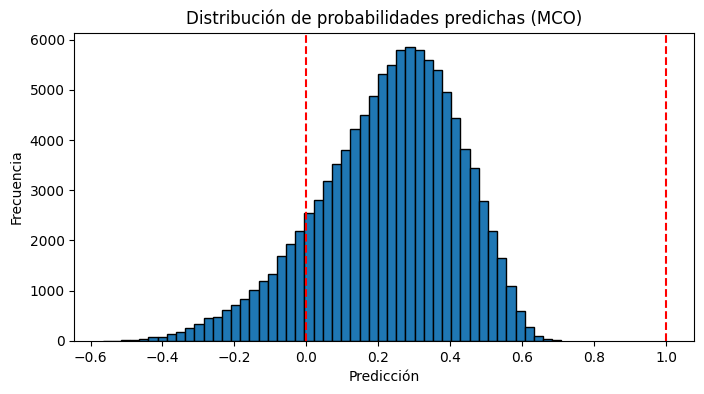

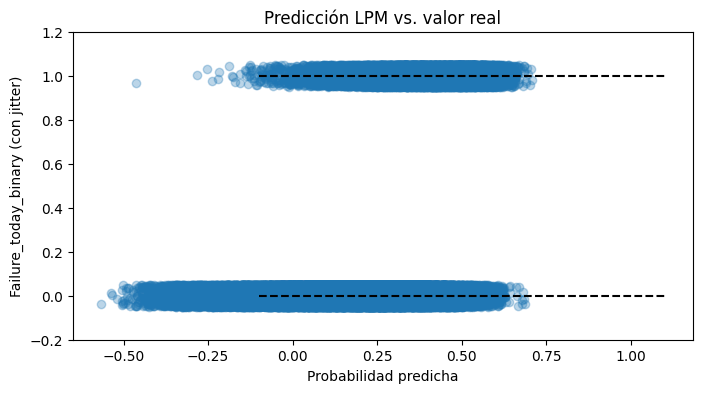

C:\Users\quilo\AppData\Local\Temp\ipykernel_27316\3691625651.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df_mco.groupby('bin').agg(


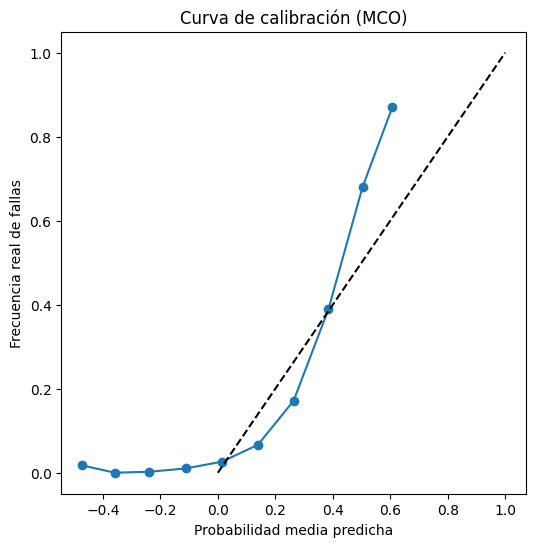

Predicciones < 0: 13976,  > 1: 0, total = 107545


In [32]:
df_mco['pred_prob'] = modelo_mco_robusto.predict(X)  # predicciones LPM

# --- 2) Histograma de predicciones ---
plt.figure(figsize=(8, 4))
plt.hist(df_mco['pred_prob'], bins=50, edgecolor='k')
plt.axvline(0, color='r', linestyle='--')
plt.axvline(1, color='r', linestyle='--')
plt.title('Distribución de probabilidades predichas (MCO)')
plt.xlabel('Predicción')
plt.ylabel('Frecuencia')
plt.show()

# --- 3) Scatter predicho vs real con jitter ---
# Añadimos algo de ruido vertical para separar puntos
y = df_mco['Failure_today_binary']
jitter = (np.random.rand(len(y)) - 0.5) * 0.1

plt.figure(figsize=(8, 4))
plt.scatter(df_mco['pred_prob'], y + jitter, alpha=0.3)
plt.hlines([0, 1], xmin=-0.1, xmax=1.1, colors='k', linestyles='--')
plt.ylim(-0.2, 1.2)
plt.title('Predicción LPM vs. valor real')
plt.xlabel('Probabilidad predicha')
plt.ylabel('Failure_today_binary (con jitter)')
plt.show()

# --- 4) Calibración simple por bines ---
df_mco['bin'] = pd.cut(df_mco['pred_prob'], bins=10)
calib = df_mco.groupby('bin').agg(
    pred_mean=('pred_prob','mean'),
    actual_mean=('Failure_today_binary','mean'),
    count=('Failure_today_binary','size')
)

plt.figure(figsize=(6, 6))
plt.plot(calib['pred_mean'], calib['actual_mean'], marker='o')
plt.plot([0,1],[0,1], 'k--')
plt.title('Curva de calibración (MCO)')
plt.xlabel('Probabilidad media predicha')
plt.ylabel('Frecuencia real de fallas')
plt.show()

# --- 5) Resumen de valores fuera de rango ---
n_below = (df_mco['pred_prob'] < 0).sum()
n_above = (df_mco['pred_prob'] > 1).sum()
print(f"Predicciones < 0: {n_below},  > 1: {n_above}, total = {len(df_mco)}")